In [4]:
#Only once when launching notebook
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')

import matplotlib.pyplot as plt
from time import time
%matplotlib widget
print("Config loaded")
print(Config.bruxisme_files)

Config loaded
[]


# Load Data Info

In [2]:
import mne
from tinnsleep.config import Config
from tinnsleep.data import CreateRaw
import pandas as pd
data_info = pd.read_csv("data/data_info.csv",engine='python', sep=",")
print(data_info[data_info["mema"]==1]["filename"])

4          1DA15_nuit_hab.edf
9          1GB18_nuit_hab.edf
22         1RA17_nuit_hab.edf
28           1HB20_nuit_1.edf
29           1HB20_nuit_2.edf
31           1SL21_nuit_4.edf
32           1SL21_nuit_6.edf
33           1SL21_nuit_7.edf
34           1SL21_nuit_8.edf
36           1SL21_nuit_2.edf
37           1SL21_nuit_3.edf
38           1SL21_nuit_5.edf
39           1UC22_nuit_2.edf
40           1UC22_nuit_1.edf
42           2GA06_nuit_1.edf
43           2SJ03_nuit_1.edf
45           2GR01_nuit_3.edf
46           2GR01_nuit_4.edf
49           2LS05_nuit_1.edf
50           2CT04_nuit_1.edf
51    1HB20_nuit_1_resmed.edf
52    1HB20_nuit_2_resmed.edf
53    1SL21_nuit_2_resmed.edf
54    1SL21_nuit_3_resmed.edf
55    1UC22_nuit_1_resmed.edf
56    1UC22_nuit_2_resmed.edf
57          1ZN04_cohort2.edf
58          1HS25_cohort2.edf
59          1PA31_cohort2.edf
60          3NS01_cohort2.edf
61          1CB23_cohort2.edf
62          1RF29_cohort2.edf
63          1GF14_cohort2.edf
64        

# Select data

In [3]:
filename = Config.bruxisme_files[0]  # load file from config
mema_files = data_info[data_info["mema"]==1]['filename'].values
assert filename.split(os.path.sep)[-1] in mema_files, f"MEMA not available for {filename.split(os.path.sep)[-1]}"
picks_chan = ['Airflow', '1', "2", "C3", "C4"]           # subset of EMG electrodes
ch_types = ["misc", "emg", "emg", "eeg", "eeg"]

start = time()

raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading
print(raw.info["ch_names"])
tmin = raw.times[0]                     
tmax = raw.times[-1]
raw  = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types=ch_types)        # pick channels and load

raw  = raw.filter(0.1, 5., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['Airflow'])
raw  = raw.filter(1, 40., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['1', '2'])
raw  = raw.filter(1, 30., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['C3', 'C4'])
ch_names = raw.info["ch_names"]
print(f"Data filtered ({time()-start:.2f}s)")
offset = raw.times[0]
print(f"keeping {(raw.times[-1]-raw.times[0])/3600:0.2f} hours of recording out of {(tmax-tmin)/3600:0.2f} hours")


IndexError: list index out of range

## Epoching data

In [11]:
from tinnsleep.data import RawToEpochs_sliding
print(ch_names)
start = time()
sfreq = raw.info["sfreq"]
window_length = 1                    # in seconds
duration = int(window_length * sfreq)   # in samples
interval = duration                     # no overlapping
epochs = RawToEpochs_sliding(raw, duration=duration, interval=interval)
print(f"Epochs done, shape {epochs.shape} in {time()-start:.2f}s")


['Airflow', '1', '2', 'C3', 'C4']
Epochs done, shape (36070, 5, 250) in 1.08s


# Annotation MEMA

In [12]:
from tinnsleep.pipeline import forward_backward_AmplitudeTresholding
import numpy as np
from tinnsleep.data import CleanAnnotations, AnnotateRaw_sliding


start = time()
selected_channels = [ch_name in ["Airflow"] for ch_name in ch_names]
print(epochs[:,selected_channels].shape)
list_labels = forward_backward_AmplitudeTresholding(epochs[:,selected_channels],
                                          window_length,
                                          length_adaptive=60,
                                          relative_threshold=3.5,
                                          max_duration_between_bursts=3
                                          )
#All episodes as tonic
list_labels[list_labels>0] = 1

print(np.unique(list_labels))

print(f"bursts count: {np.sum(list_labels)}/{len(list_labels)} ({np.sum(list_labels) / len(list_labels) * 100:.2f}%)")
print(f"bursts time: {np.sum(list_labels) * window_length} seconds")
print(f"Classification done in {time()-start:.2f}s")
list_labels_mema = list_labels

start = time()
dict_annotations = {1: "MEA"}
raw = CleanAnnotations(raw)
raw = AnnotateRaw_sliding(raw, list_labels, 
                dict_annotations=dict_annotations, duration=duration, interval=interval, merge=True)
print(f"Raw annotated in {time()-start:.2f}s")

(36070, 1, 250)
[0. 1.]
bursts count: 1039.0/36070 (2.88%)
bursts time: 1039.0 seconds
Classification done in 8.10s
Raw annotated in 0.04s


# Annotation EMG

In [13]:
from tinnsleep.pipeline import forward_backward_AmplitudeTresholding
import numpy as np
from tinnsleep.data import CleanAnnotations, AnnotateRaw_sliding


start = time()
selected_channels = [ch_name in ["1", "2"] for ch_name in ch_names]
print(epochs[:,selected_channels].shape)
list_labels = forward_backward_AmplitudeTresholding(epochs[:,selected_channels],
                                          0.25,
                                          length_adaptive=60,
                                          relative_threshold=3.5,
                                          max_duration_between_bursts=3
                                          )
#All episodes as tonic
list_labels[list_labels>0] = 2

print(np.unique(list_labels))

print(f"bursts count: {np.sum(list_labels)}/{len(list_labels)} ({np.sum(list_labels) / len(list_labels) * 100:.2f}%)")
print(f"bursts time: {np.sum(list_labels) * window_length} seconds")
print(f"Classification done in {time()-start:.2f}s")
list_labels_emg = list_labels

start = time()
dict_annotations = {2: "EMG"}
raw = AnnotateRaw_sliding(raw, list_labels, 
                dict_annotations=dict_annotations, duration=duration, interval=interval, merge=True)
print(f"Raw annotated in {time()-start:.2f}s")

(36070, 2, 250)
[0. 2.]
bursts count: 2504.0/36070 (6.94%)
bursts time: 2504.0 seconds
Classification done in 8.65s
Raw annotated in 0.07s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

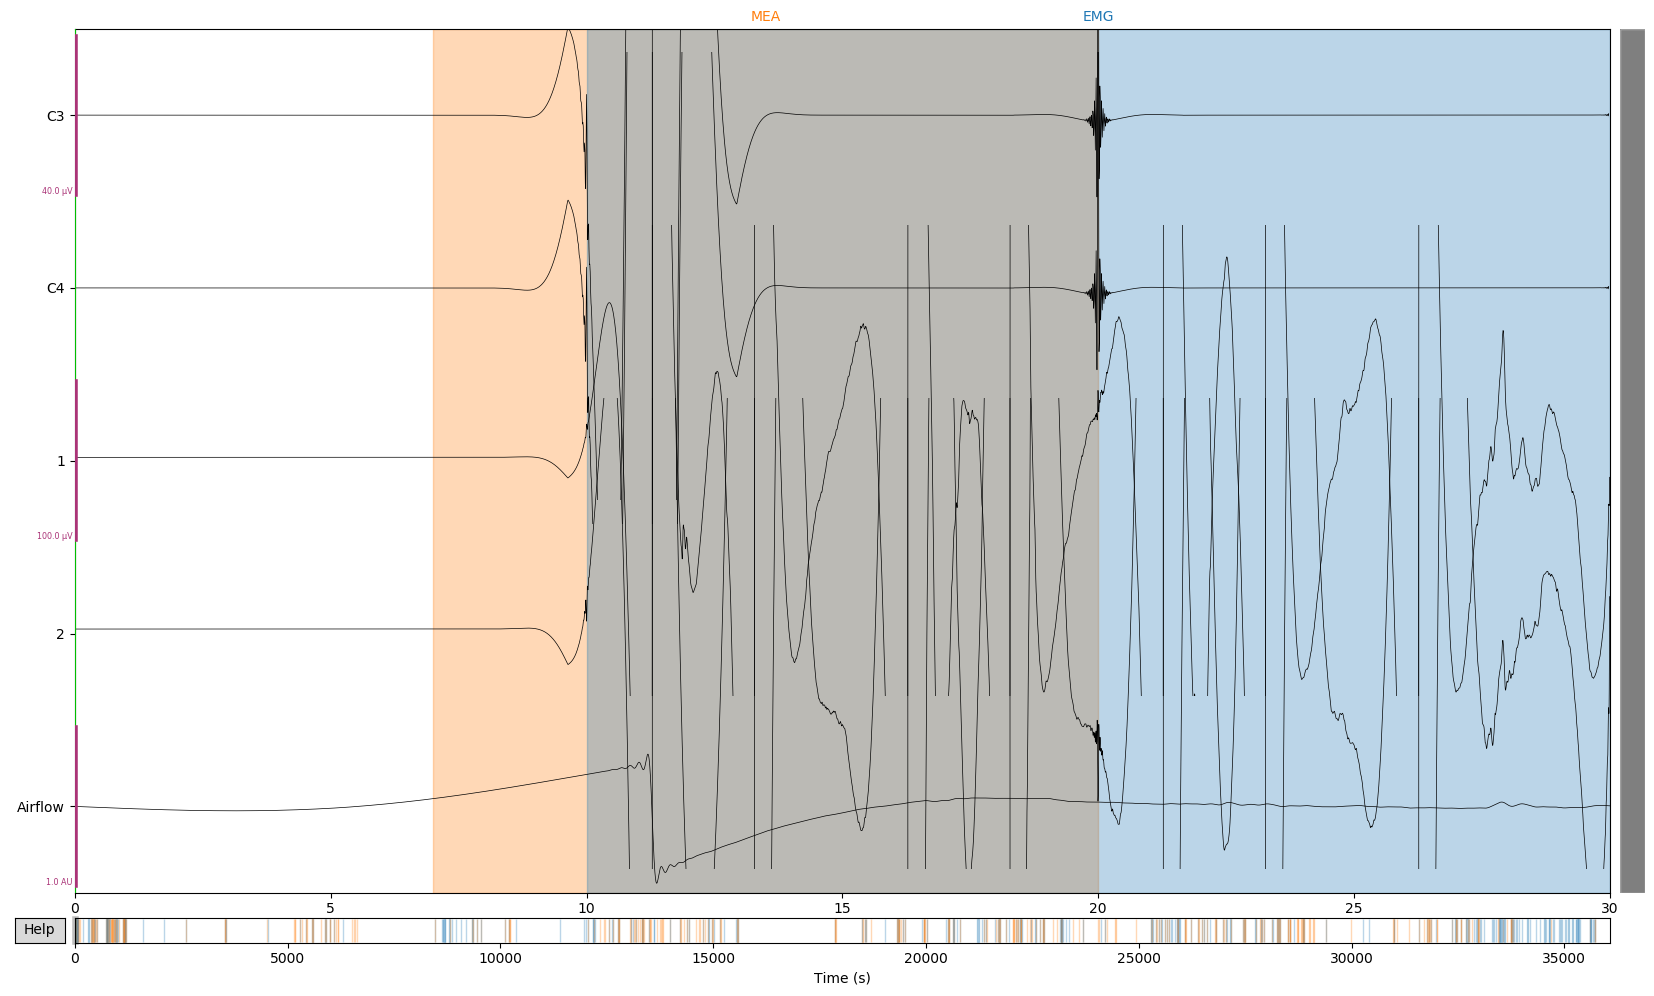

In [20]:
scalings = dict(misc=0.5, emg=5e-5)
raw.plot(scalings = scalings, duration = 30)